# Lab9 / simple autoencoder : using Mnist dataset

## Overview

在此lab中，我們使用lab5使用的Mnist手寫數字影像資料集，將影像先encode再decode回原始圖片維度，模型的loss為輸出影像（autoencoder後的影像）和原始影像的誤差，最小化這個誤差，使輸出圖片接近原始圖片。


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from scipy import spatial
import random
import os
import cv2
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


## Load data and plot data image

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

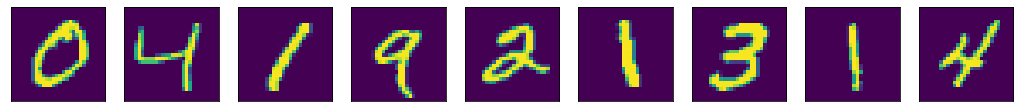

In [3]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Data description

+ x_train的維度: (60000, 28, 28) 60000筆28x28的影像
+ y_train的維度: (60000,) 60000筆x_train影像的正確數字
+ x_test的維度: (10000, 28, 28) 10000筆28x28的影像
+ y_test的維度: (10000,) 10000筆x_test影像的正確數字

In [4]:
# 看訓練資料跟測試資料的維度。
print("x_train的維度: " + str(x_train.shape)) # (60000, 28, 28)
print("y_train的維度: " + str(y_train.shape))# (60000,)
print("x_test的維度: " + str(x_test.shape)) # (10000, 28, 28)
print("y_test的維度: " + str(y_test.shape)) # (10000,)

x_train的維度: (60000, 28, 28)
y_train的維度: (60000,)
x_test的維度: (10000, 28, 28)
y_test的維度: (10000,)


此資料集中有x（圖片）與y (圖片對應正確數字)，我們只會用到圖片部分：x_train和x_test，來訓練此autoencoder模型。

x_train為training set，x_test做為validation set。

## Preprocessing
正規化資料數值範圍至 [0, 1] 間

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

將維度28x28的影像reshape成長度784的array

In [6]:
x_train = x_train.reshape(x_train.shape[0], -1) # The "-1" makes reshape flatten the remaining dimensions
x_test = x_test.reshape(x_test.shape[0], -1)

In [7]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## Build autoencoder architecture

In [12]:
inputs = tf.keras.Input(shape=(784,))
 
# encoder
encoded = tf.keras.layers.Dense(128, activation='relu')(inputs)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(10, activation='relu')(encoded)
encoder_output = tf.keras.layers.Dense(2)(encoded)
# 128,64,10
# decoder
decoded = tf.keras.layers.Dense(10, activation='relu')(encoder_output)
decoded = tf.keras.layers.Dense(64, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)
 
encoder = tf.keras.Model(inputs=inputs,outputs=encoder_output)
autoencoder = tf.keras.Model(inputs=inputs, outputs=decoded)
 
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
Total params: 463,180
Trainable params: 463,180
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               64128     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 102       
_________________________________________________________________
dense_12 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               6528

In [15]:
# training
autoencoder.fit(x_train, x_train, epochs=30, batch_size=256, shuffle=True,validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 2s 31us/sample - loss: 0.2641 - val_loss: 0.2199
Epoch 2/30
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2114 - val_loss: 0.2021
Epoch 3/30
60000/60000 [==============================] - 2s 26us/sample - loss: 0.1987 - val_loss: 0.1944
Epoch 4/30
60000/60000 [==============================] - 1s 14us/sample - loss: 0.1911 - val_loss: 0.1882
Epoch 5/30
60000/60000 [==============================] - 1s 22us/sample - loss: 0.1860 - val_loss: 0.1847
Epoch 6/30
60000/60000 [==============================] - 2s 26us/sample - loss: 0.1822 - val_loss: 0.1818
Epoch 7/30
60000/60000 [==============================] - 2s 25us/sample - loss: 0.1794 - val_loss: 0.1788
Epoch 8/30
60000/60000 [==============================] - 1s 24us/sample - loss: 0.1773 - val_loss: 0.1772
Epoch 9/30
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1764 - val_

## Plot encoder result

在訓練完autoencoder後，我們只先使用前面的encoder部分predict x_test圖片，將其2維結果畫在一平面上，並標上每個點對應的y_test(顏色)。

可以看到encoder的結果就像壓縮一樣將其特徵壓縮成2維（降維），且成功將不同的數字區分開來。

In [16]:
### 使用encoder層model predict , input 為x_test
test_encode = encoder.predict(x_test)

In [17]:
test_encode.shape #維度(10000,2) 每筆資料被壓縮成2維特徵

(10000, 2)

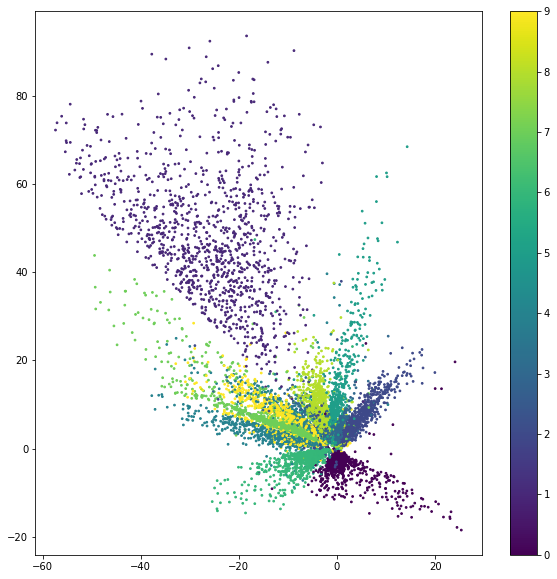

In [18]:
plt.figure(figsize=(10, 10))
plt.scatter(test_encode[:, 0], test_encode[:, 1], c=y_test, s=3)
plt.colorbar()
plt.show()

## Image retreival : using encoder feature

了解到encoded結果的2維特徵能成功的分群出數字後，我們也能使用這層的特徵來搜尋相似的影像。

In [19]:
train_encode = encoder.predict(x_train)

In [20]:
train_encode.shape

(60000, 2)

用test的encoded output其中一筆作為query資料，搜尋在train encoded output中與他最像的前5筆資料

In [46]:
similarity = []

# 從test_encode中取一筆query資料
query_index = 15
query = test_encode[query_index]

# 計算query與全部train_encode資料的相似度
for j in train_encode:
    # cosine similarity = 1 - cosine distance
    cosine = 1 - spatial.distance.cosine(query,j)
    similarity.append(cosine)
similarity = pd.Series(similarity)

#依相似度做降冪排序
sorting = similarity.sort_values(ascending=False)

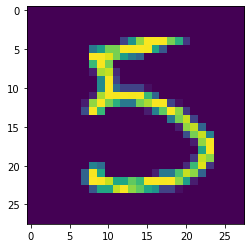

In [50]:
#畫出query圖片
plt.figure(figsize=(20, 4))
plt.imshow(x_test[query_index].reshape(28, 28))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


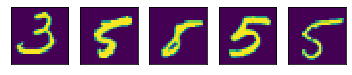

In [51]:
#畫出與query最像的5筆圖片
top_n = 5
for num,i in enumerate(sorting.index[0:top_n]):
    ax = plt.subplot(2, top_n, num + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## autoencoder 解壓

In [33]:
result = autoencoder.predict(x_train)

## Plot original input image and autoencoder result

畫出原始input圖片與autoencoder的output圖片

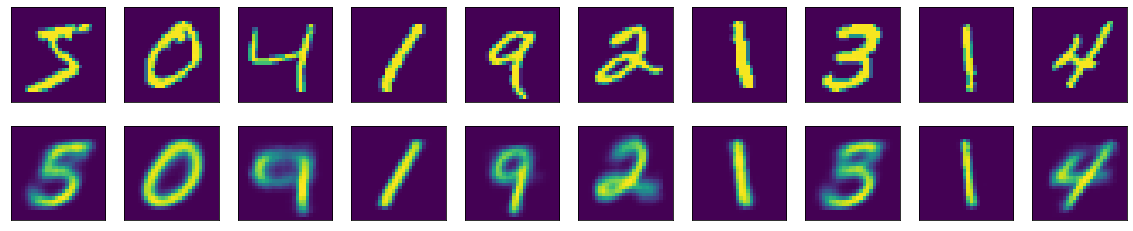

In [34]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(result[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

> 請嘗試調整模型、訓練參數，最小化loss，並查看image retreival結果與原始、解壓圖片的差異